<a href="https://pangeos.eu/" target="_blank">
<center><img src="../images/1-logos.png" alt="logos" width="100%"/></center>
</a>

PANGEOS summer taining school 2024

EXAMPLE OF UNCERTAINTY PROPAGATION FOR 

# CASE 1: "Ground based reflectance retrieval using a dual-field-of-view spectrometer system"

**Authors:**
L. Mihai (laura.mihai@inflpr.ro) and A. Bialek (agnieszka.bialek@npl.co.uk)

# Learning objectives

**After follwing this notebook you will be able to ...**
- Explain the two uncertainty ($U_T$) components, random $U_R$ and systematic $U_S$
- Compute $U_R$ from measurement repetitions
- Assign the magnitude of $U_S$ due to calibration uncertainty
- Propagate both uncertainty components through the functions with `punpy`
- Compute and explain error correlation matrix

# TOC

1. [Introduction](#1)
2. [Reading and understanding Piccolo doppio spectrometer data](#2)
   1. [2-1](#2-1) Raw digital numbers (DNs)
   2. [2-2](#2-2) Dark noise subtraction and Integration time correction
   3. [2-3](#2-3) Calibration to actual physical units
3. [Uncertainty quantification steps](#3)
   1. [Step 1](#Step-1): Trace the traceability chain
   2. [Step 2](#Step-2): Take Your Measurements & Write down the measurement equation
   3. [Step 3](#Step-3): Estimate the uncertainty of each input quantity that feeds into the final result
   4. [Step 4](#Step-4): Assess Independence of Input Quantities
   5. [Step 5](#Step-5): Calculate the Measurement Result
   6. [Step 6](#Step-6): Find the Combined Standard Uncertainty - u_c
   7. [Step 7](#Step-7): Propagate Input Uncertainty
   8. [Step 8](#Step-8): Document the Measurement Result and Uncertainty
4. [Actual computations of uncertainty](#4)
   1. [4-1](#4-1) Radiance
       1. [4-1-1](#4-1-1) plot spectra and uncertainty in absolute units
       2. [4-1-2](#4-1-2) plot uncertainty in the relative units
       3. [4-1-3](#4-1-3) plot correlation matrix
   3. [4-2](#4-2) Irradiance
   4. [4-3](#4-3) Reflectance
5. [Analysis and export](#5)
   1. [5-1](#5-1) Plotting all together
   2. [5-2](#5-2) Export reflectance and uncertainty as pandas DataFrame

# 1
## Introduction

In this notebook we present a simple example on how to propagate uncertainties for a field reflectance measurement using **METHOD 1**, taking into account only the **uncertainty from the instrument calibration certificate**. 

**METHOD 1** is based on field reflectance measurements using a spectrometer system (Piccolo doppio) with dual-field-of-view having a cosine diffuser fore optic to capture down-welling irradiance and a view angle limited fore optic to capture up-welling radiance, measuring reflectance across the 400 nm to 1,000 nm (VNIR) spectral range. Thus, the calibration for **two** systems is considered: 
1. the one measuring the spectral irradiance 
2. that one measuring the spectral radiance.

The propagation of uncertainties within this session will be done using the **Comet-toolkit** together with the punpy tool. The **CoMet Toolkit** (Community Metrology Toolkit) is an open-source software project to develop Python tools for the handling of error-covariance information in the analysis of measurement data. *punpy* is a tool for “Propagation of UNcertainties in Python” and has been developed by Pieter De Vis from NPL. *punpy* propagates uncertainties on input quantities through any python function, evaluating the uncertainty on the output. These input data uncertainties can be defined using obsarray.

Details about Comet-toolkit and punpy you can find here: 
https://punpy.readthedocs.io/en/latest/ ; https://www.comet-toolkit.org/about/

<table>
    <tr>
        <td> 
            <a href="https://punpy.readthedocs.io/en/latest/" target="_blank">
                <center><img src="../images/logo-punpy.webp" alt="logo-punpy" width="40%"/></center>
            </a>
        <td> 
            <a href="https://www.comet-toolkit.org/about/" target="_blank">
                <center><img src="../images/logo-comet.svg" alt="logo-comet" width="50%"/></center>
            </a>
    </tr>
    </table>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import punpy

from pathlib import Path

plt.rcParams.update({'font.size': 16})

# 2
## Piccolo data reading

For details on data reading, please, refer to the notebook [case_1-Ex0-Piccolo.ipynb](case_1-Ex0-Piccolo.ipynb)

Reflectance measurements using a spectrometer system (Piccolo doppio)

[back to TOC](#TOC)

In [2]:
data_dir = Path(r'../data/case1-set1')

data = {}

for path_txt in data_dir.glob("*.txt"):
    key = path_txt.name.replace('.txt', '')
    with open(path_txt, "r") as f:
        data[key] = np.loadtxt(f)

In [3]:
# common inputs
pi = np.pi;
Wvl = data['WavelengthS2_Rad']

#### Radiance (L)

In [4]:
# your data for Radiance sensor
DataL0_Rad = data['S2_lg_Rad']  # light signal (measurement)
N_L = DataL0_Rad.shape[1] # the number of light measurements
print(N_L, 'repetitions of light measurements')

Datadark_Rad = data['S2_dk_Rad']  # dark signal (noise)
M_L = Datadark_Rad.shape[1]  # the number of dark measurements
print(M_L, 'repetitions of dark noise measurements')

IT_Rad = data['S2_IT_Rad']  # integration time
print(IT_Rad, 'ms integration time')

cal_coef_L0 = data['CcalS2_L']  # calibration coefficients from lab calibration

20 repetitions of light measurements
20 repetitions of dark noise measurements
65.0 ms integration time


#### Irradiance (E)

In [5]:
# data for Irradiance sensor
DataE0_Irrad = data['S2_lg_Irrad']
N_E = DataE0_Irrad.shape[1]
print(N_E, 'repetitions of light measurements')

Datadark_Irrad = data['S2_dk_Irrad']
M_E = Datadark_Irrad.shape[1]
print(M_E, 'repetitions of dark measurements')

IT_Irrad = data['S2_IT_Irrad']
print(IT_Irrad, 'ms integration time')

cal_coef_E0 = data['CcalS2_E'] 

20 repetitions of light measurements
20 repetitions of dark measurements
58.0 ms integration time


#### Integration time correction

In [6]:
def integration_time_normalisation(DN, IT):
    return DN / IT 

In [7]:
L0 = integration_time_normalisation(DataL0_Rad, IT_Rad)
dark_L0 = integration_time_normalisation(Datadark_Rad, IT_Rad)

E0 = integration_time_normalisation(DataE0_Irrad, IT_Irrad)
dark_E0 = integration_time_normalisation(Datadark_Irrad, IT_Irrad)

this is the time to average raw measurements

later we are going to compute radom uncertainty from this repetitions but now we keep them as is

In [8]:
L0_m = np.mean(L0, axis=1)
dark_L0_m = np.mean(dark_L0, axis=1)

E0_m = np.mean(E0, axis=1)
dark_E0_m = np.mean(dark_E0, axis=1)


#### Calibration coefficients application and nark noise subtraction
**the calibration functions for radiance and irradiance sensors**

[back to TOC](#TOC)

In [9]:
def calibrate(light_meas, dark_meas, cal_coef):
    return (light_meas - dark_meas) * cal_coef

In [10]:
def deriveR(L, E):
    return  (pi * L) / E

In [11]:
L1 = calibrate(L0_m, dark_L0_m, cal_coef_L0) # calibration coefficients for signal without nonlin applied

E1 = calibrate(E0_m, dark_E0_m, cal_coef_E0) # calibration coefficients for signal without nonlin applied

R1_abs = deriveR(L1, E1)

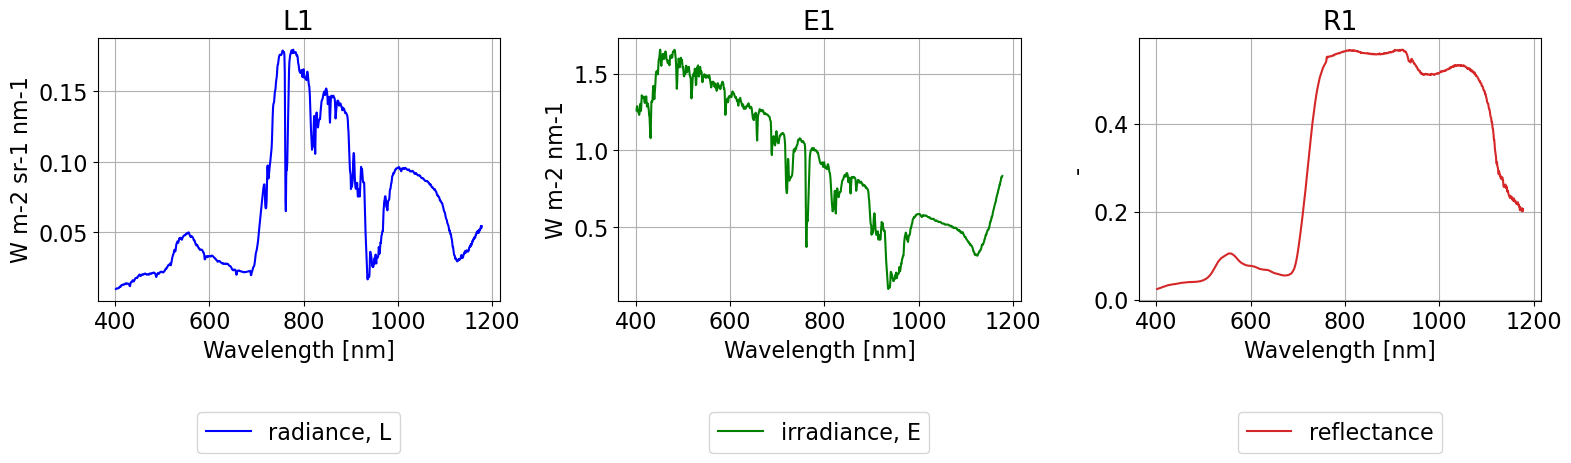

In [37]:
_, axs = plt.subplots(1, 3, figsize=(16, 4.5), tight_layout=True, sharex=True)

ax = axs[0]
ax.plot(Wvl, L1, 'b', label='radiance, L')
ax.set_title('L1')
ax.set_ylabel('W m-2 sr-1 nm-1')

ax = axs[1]
ax.plot(Wvl, E1, 'g', label='irradiance, E')
ax.set_title('E1')
ax.set_ylabel('W m-2 nm-1')

ax = axs[2]
ax.plot(Wvl, R1_abs, 'tab:red', label='reflectance')
ax.set_title('R1')
ax.set_ylabel('-')

for ax in axs:
    ax.set_xlabel('Wavelength [nm]')
    ax.grid()
    ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

# 3
## Uncertainty quantification steps

[back to TOC](#TOC)

# 3. Take the checklist for uncertainty analysis steps and try to follow each step. 
*NOTE! You have it printed on table.*

## Step 1
**STEP 1 - Trace the traceability chain**: at the base of traceability chain is your instrument (in this case spectrometer system (Piccolo doppio) with dual-field-of-view, 1 with cosine diffuser FO and 1 with FOV 25%). This instrument it is calibrated using two secondary standards (by NMI in your country or a metrology lab. with traceability to SI): one radiance standard (that can be an integrating sphere or an irradiance standard with a reflectance panel) and one is the irradiance standard. The secondary standards are calibrated agains primary standards (in general cryogenic radiometer) that defines the unit of spectral radiance (W/m2 sr nm) or irradiance (W/m2 nm).

 - Interactive Task: Create a simple flowchart showing how your instrument connects to the primary standard. What are the intermediate standards involved? This visual representation will help clarify the chain of accuracy!

[back to TOC](#TOC)

## Step 2
**STEP 2 - Take Your Measurements & Write down the measurement equation**. 

- What to Do: Conduct your measurements and write down the measurement equation you’ll be using.
Since you need to derive the absolute reflectance, your equation will be:
   
$R_{abs} = \dfrac{\pi \cdot L [SI units]}{E [SI units]}$

- Interactive Task: Record your measurements in a table. What did you measure, and what units did you use? Share your measurement equation with a peer to compare!

[back to TOC](#TOC)

## Step 3
**STEP 3 - Estimate the uncertainty of each input quantity that feeds into the final result**. 

- What to Do: Determine the uncertainty for each input quantity that contributes to your final result. This includes Type A (statistical) and Type B (non-statistical) uncertainties. Express all uncertainties in similar terms (standard uncertainties, u).
  
Interactive Task: Sketch a tree diagram to visualize how each input feeds into the final result. 

<center><img src="../images/1-u-tree-diagram.png" alt="logos" width="100%"/></center>

[back to TOC](#TOC)

What uncertainties did you identify? How do they interconnect? Separate then in systematic and random uncertainties.

#### Uncertainties
- random [during measurements] $U_R$
  
$U_R = \dfrac{\sigma}{\sqrt N}$

- systematic [during calibration] $U_S$


#### $U_R$ random uncertainty

In [13]:
### ex. random effects: instrument noise
L0_ur = np.std(L0, axis=1) / (N_L**0.5) # meas noise for light
dark_L0_ur = np.std(dark_L0, axis=1) / (M_L**0.5) # meas noise for dark

E0_ur = np.std(E0, axis=1) / (N_E**0.5) # meas noise for light
dark_E0_ur = np.std(dark_E0, axis=1) / (M_E**0.5) # meas noise for dark

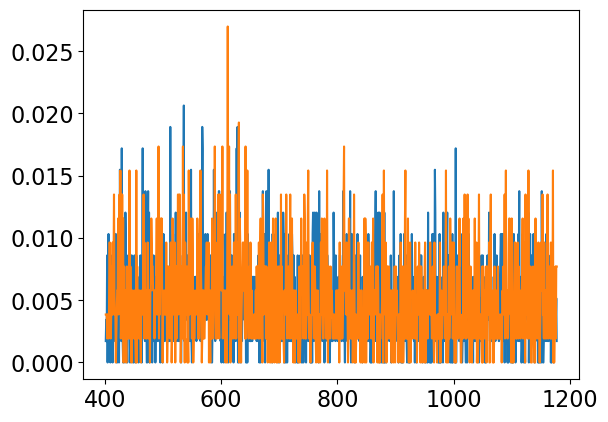

In [14]:
plt.plot(Wvl, dark_L0_ur)
plt.plot(Wvl, dark_E0_ur)

#### $U_S$ systematic uncertainty

In [15]:
# systematic effects:
# instrument calibration:
# L0_cert_us_abs=data['L0_cert_us_abs']
L0_assumed_us_perc = 3 # in percents
L0_cert_us_rel = np.ones(1036) * L0_assumed_us_perc / 100
cCalL_us_abs = L0_cert_us_rel*cal_coef_L0 # is the absolute uncertainty of the standard instrument used for calibration

# calibration uncertainty:
# E0_cert_us_abs=data['E0_cert_us_abs']
E0_assumed_us_perc = 2 # in percents
E0_cert_us_rel = np.ones(1036) * E0_assumed_us_perc / 100
cCalE_us_abs = E0_cert_us_rel * cal_coef_E0

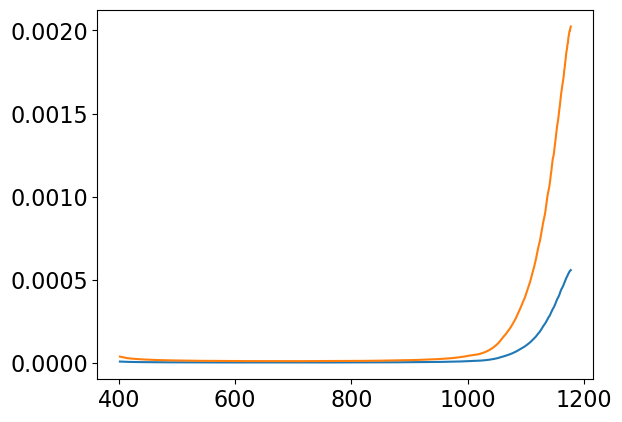

In [16]:
plt.plot(Wvl, cCalL_us_abs)
plt.plot(Wvl, cCalE_us_abs)

## Step 4
**STEP 4 - Assess Independence of Input Quantities**

- What to Do: Decide whether the errors of your input quantities are independent of each other. If not, you may need additional calculations or information.
- Interactive Task: Discuss with a partner: Do you think any of your input uncertainties influence each other? How would you handle that?

[back to TOC](#TOC)

## Step 5
**Step 5: Calculate the Measurement Result**

- What to Do: Calculate your measurement result, including any necessary corrections (e.g., calibration adjustments). Also, determine the sensitivity coefficients for each input.
- Interactive Task: Share your calculations with a classmate. Do your results match? - What corrections did you apply, and why?

[back to TOC](#TOC)

## Step 6
**Step 6: Find the Combined Standard Uncertainty - u_c**

- What to Do: Combine the uncertainties from all individual aspects to find the overall standard uncertainty. Assign uncertainties appropriately based on your earlier steps.
- Interactive Task: Create a list of all uncertainties and their contributions to the combined standard uncertainty. How do these uncertainties impact the overall result?

[back to TOC](#TOC)

## Step 7
**Step 7: Propagate Input Uncertainty**

- What to Do: Use your measurement equation to propagate the input uncertainties. This will help you understand how uncertainties combine and affect your final measurement.
  
  Expanded uncertainty **U** = coverage factor **k** x combined standard uncertainty **u_total**.
  
    • k = 2 for confidence level of 95 % (Most common)
  
    • k = 1 confidence level of approximately 68 %
  
    • k = 2.58 confidence level of 99 %
  
    • k = 3 confidence level of 99.7 %

- Interactive Task: Work in small groups to practice propagating uncertainties using different measurement equations. Can you find any patterns in how uncertainties propagate?

[back to TOC](#TOC)

## Step 8
**Step 8: Document the Measurement Result and Uncertainty**

- What to Do: Write down your final measurement result and the associated uncertainty in a document. Be sure to express the uncertainty using a coverage factor or by stating the size of the uncertainty interval, along with the level of confidence.

` Result = Measured Value ± Uncertainty U`
  
- Interactive Task: Present your findings to the group. How did you express the uncertainty? What level of confidence did you achieve? Engage in a discussion about different ways to communicate uncertainty.

[back to TOC](#TOC)

# 4
## Actual computations of uncertainty


[back to TOC](#TOC)

For this example we will use MC propagation method. 

You can find an example on how to use the Low of Propagation Uncertainties (LPU) here:
https://github.com/comet-toolkit/comet_training/blob/main/punpy_standalone_example_LPUdetail.ipynb

## 4-1
### Radiance
[back to TOC](#TOC)

In [17]:
# uncertainty propagation for your field reflectance data using only 
# the calibration uncertainty and calibration coefficients together with dark and light field data

prop = punpy.MCPropagation(10000)

L1 = calibrate(L0_m, dark_L0_m, cal_coef_L0)

L1_ur = prop.propagate_random(calibrate,
                              [L0_m, dark_L0_m, cal_coef_L0],
                              [L0_ur, dark_L0_ur, np.zeros(1036)]) # 

L1_us = prop.propagate_systematic(calibrate, 
                                  [L0_m, dark_L0_m, cal_coef_L0], 
                                  [np.zeros(1036), np.zeros(1036), cCalL_us_abs]) # systematic uncertainty (calibration)

L1_ut = (L1_ur**2 + L1_us**2)**0.5 # total uncertainty

L1_cov = punpy.convert_corr_to_cov(np.eye(len(L1_ur)), L1_ur) + \
         punpy.convert_corr_to_cov(np.ones((len(L1_us),len(L1_us))), L1_us)

L1_corr = punpy.correlation_from_covariance(L1_cov)
print("L1:    ",L1)
print("L1_ur: ",L1_ur)
print("L1_us: ",L1_us)
print("L1_ut: ",L1_ut)
print("L1_cov:\n",L1_cov)
print("L1_corr:\n",L1_corr)

L1:     [0.00974077 0.01005097 0.01018032 ... 0.05441448 0.05298046 0.05441782]
L1_ur:  [5.01218022e-05 5.81984569e-05 5.68133772e-05 ... 6.28081618e-04
 5.40033668e-04 4.64353998e-04]
L1_us:  [0.00029161 0.0003009  0.00030477 ... 0.001629   0.00158607 0.0016291 ]
L1_ut:  [0.00029589 0.00030647 0.00031002 ... 0.00174589 0.00167549 0.00169399]
L1_cov:
 [[8.75480951e-08 8.77439617e-08 8.88731401e-08 ... 4.75032771e-07
  4.62513903e-07 4.75061872e-07]
 [8.77439617e-08 9.39253249e-08 9.17034029e-08 ... 4.90160711e-07
  4.77243166e-07 4.90190739e-07]
 [8.88731401e-08 9.17034029e-08 9.61112953e-08 ... 4.96468597e-07
  4.83384816e-07 4.96499012e-07]
 ...
 [4.75032771e-07 4.90160711e-07 4.96468597e-07 ... 3.04814378e-06
  2.58372359e-06 2.65381983e-06]
 [4.62513903e-07 4.77243166e-07 4.83384816e-07 ... 2.58372359e-06
  2.80726929e-06 2.58388187e-06]
 [4.75061872e-07 4.90190739e-07 4.96499012e-07 ... 2.65381983e-06
  2.58388187e-06 2.86960704e-06]]
L1_corr:
 [[1.         0.96761487 0.96885762 .

### 4-1-1
#### plot uncertainty in the absolute units
[back to TOC](#TOC)

In [18]:
def plot_absolute_u(Wvl, x, ur, us, ut, label, units, symbol):
    _, axs = plt.subplots(1, 3, figsize=(16, 4.5), tight_layout=True)
    
    ax = axs[0]
    ax.fill_between(Wvl, x - ur, x + ur, color="blue", alpha=0.3, label="random uncertainty")
    ax.set_title(f"{symbol} U$_R$")
    
    ax = axs[1]
    ax.fill_between(Wvl, x - us, x + us, color="green", alpha=0.3, label="systematic uncertainty") 
    ax.set_title(f"{symbol} U$_S$")
    
    ax = axs[2]
    ax.fill_between(Wvl, x - ut, x + ut, color="red", alpha=0.3, label="total uncertainty")
    ax.set_title(f"{symbol} U$_T$")
    
    for ax in axs:
        ax.plot(Wvl, x, color="black", label=label)
        ax.set_xlabel("Wavelength (nm)")
        ax.set_ylabel(units)
    
        ax.grid()
        ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

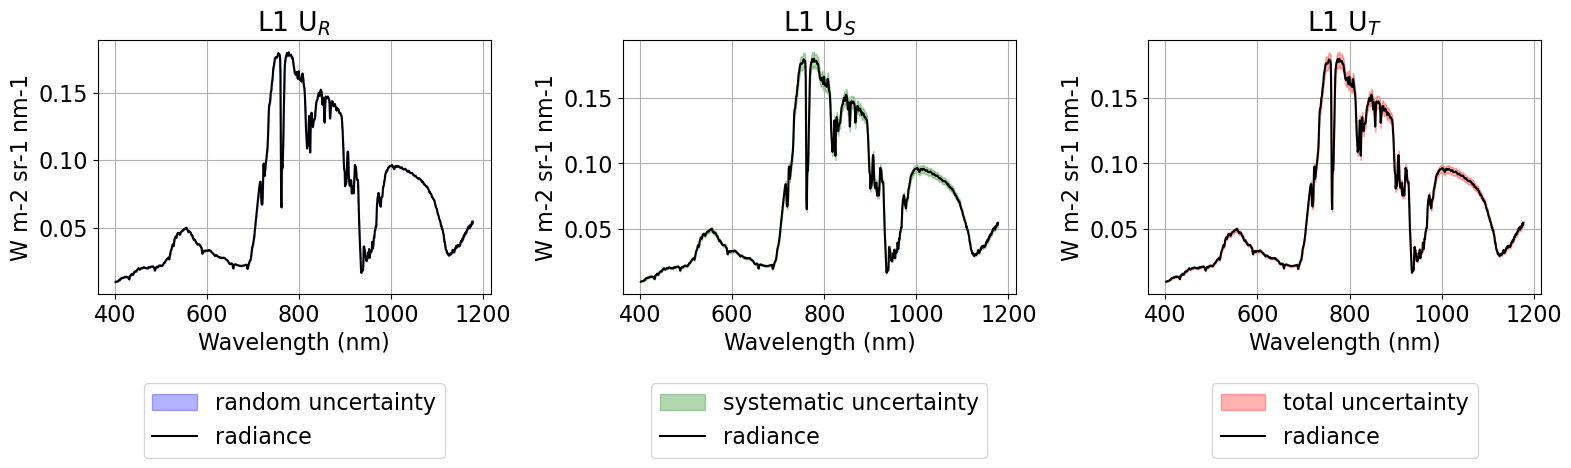

In [19]:
label = 'radiance'
units = 'W m-2 sr-1 nm-1'
symbol = 'L1'

plot_absolute_u(Wvl, L1, L1_ur, L1_us, L1_ut, label, units, symbol)

### 4-1-2
#### plot uncertainty in the relative units
[back to TOC](#TOC)

In [20]:
def plot_relative_u(Wvl, x, ur, us, ut, units, symbol):
    _, axs = plt.subplots(1, 3, figsize=(16, 4.5), tight_layout=True)
    
    ax = axs[0]
    ax.plot(Wvl, ur / x * 100, color="blue", label="random uncertainty")
    ax.set_title(f"{symbol} U$_R$")
    
    ax = axs[1]
    ax.plot(Wvl, us / x * 100, color="green", label="systematic uncertainty") 
    ax.set_title(f"{symbol} U$_S$")
    
    ax = axs[2]
    ax.plot(Wvl, ut / x * 100, color="red", label="total uncertainty")
    ax.set_title(f"{symbol} U$_T$")
    
    for ax in axs:
        ax.set_xlabel("Wavelength (nm)")
        ax.set_ylabel(units)
        ax.grid()
        ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')
        ax.set_ylim([0, 5])

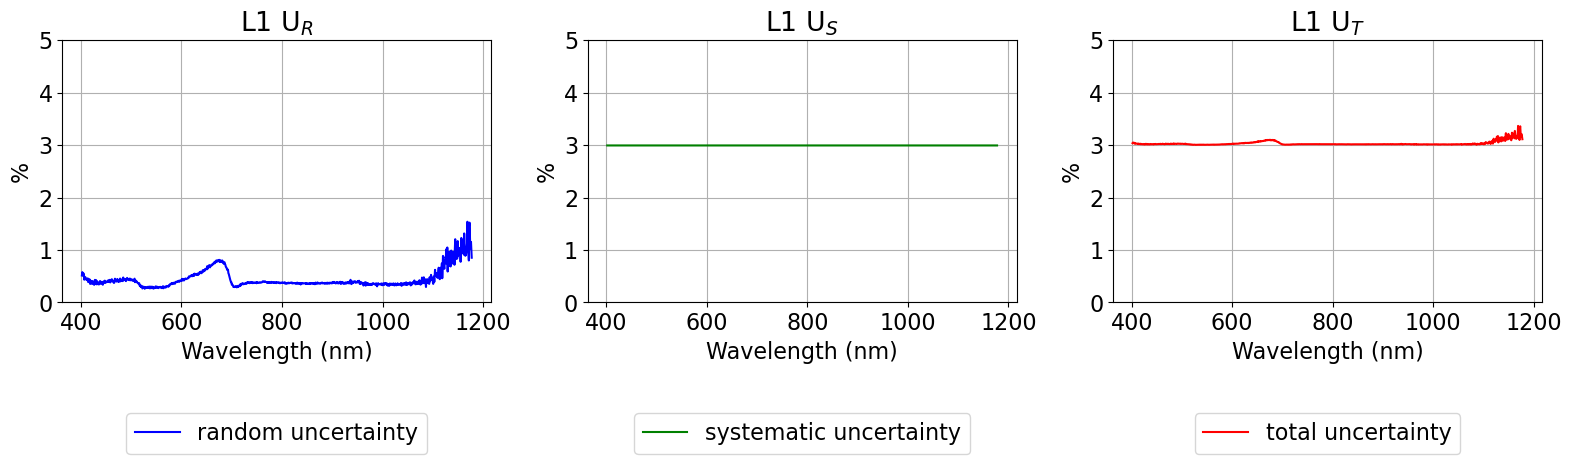

In [21]:
units = '%'
symbol = 'L1'

plot_relative_u(Wvl, L1, L1_ur, L1_us, L1_ut, units, symbol)

### 4-1-3
#### correlation matrix
[back to TOC](#TOC)

In [22]:
def plot_cor_mat(cor_mat, symbol, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    
    im = ax.imshow(cor_mat)
    plt.colorbar(im, label='Correlation coefficient')
    ax.set_title(f"{symbol} correlation")
    
    n_wl = Wvl.size
    ticks = ax.get_xticks()
    ticks = ticks[(ticks >= 0) & (ticks < n_wl)].astype(int)
    tick_labels = Wvl[ticks].astype(int)
    ax.set_xticks(ticks);
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel("Wavelength (nm)")
    
    ticks = ax.get_yticks()
    ticks = ticks[(ticks >= 0) & (ticks < n_wl)].astype(int)
    tick_labels = Wvl[ticks].astype(int)
    ax.set_yticks(ticks);
    ax.set_yticklabels(tick_labels)
    ax.set_ylabel("Wavelength (nm)")

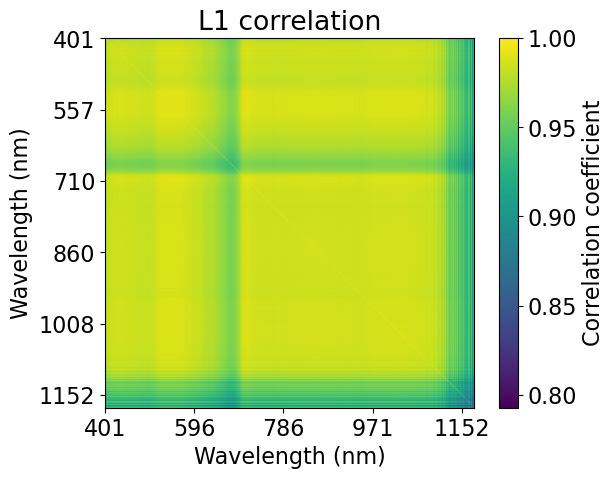

In [23]:
plot_cor_mat(L1_corr, 'L1')

## 4-2
### irradiance
[back to TOC](#TOC)

propagate uncertainties for spectral irradiance:

In [24]:
#uncertainty propagation for your field reflectance data using only 
#the calibration uncertainty and calibration coefficients together with dark and light field data

prop = punpy.MCPropagation(10000)

E1 = calibrate(E0_m, dark_E0_m, cal_coef_E0)

E1_ur = prop.propagate_random(calibrate, 
                              [E0_m, dark_E0_m, cal_coef_E0], 
                              [E0_ur, dark_E0_ur, np.zeros(1036)]) # 

E1_us = prop.propagate_systematic(calibrate, 
                                  [E0_m, dark_E0_m, cal_coef_E0], 
                                  [np.zeros(1036), np.zeros(1036),cCalE_us_abs]) # systematic uncertainty (calibration)

E1_ut = (E1_ur**2 + E1_us**2)**0.5 # total uncertainty

E1_cov = punpy.convert_corr_to_cov(np.eye(len(E1_ur)), E1_ur) + \
         punpy.convert_corr_to_cov(np.ones((len(E1_us), len(E1_us))),E1_us)

E1_corr = punpy.correlation_from_covariance(E1_cov)
print("E1:    ", E1)
print("E1__ur: ", E1_ur)
print("E1_us: ", E1_us)
print("E1_ut: ", E1_ut)
print("E1_cov:\n", E1_cov)
print("E1_corr:\n", E1_corr)

E1:     [1.25989073 1.28534634 1.28774607 ... 0.82331551 0.82963833 0.83299351]
E1__ur:  [0.00337632 0.00357085 0.00337436 ... 0.00468056 0.00421098 0.00399874]
E1_us:  [0.02552209 0.02603775 0.02608636 ... 0.01667822 0.0168063  0.01687427]
E1_ut:  [0.02574445 0.02628147 0.0263037  ... 0.01732254 0.01732582 0.01734159]
E1_cov:
 [[0.00066278 0.00066454 0.00066578 ... 0.00042566 0.00042893 0.00043067]
 [0.00066454 0.00069072 0.00067923 ... 0.00043426 0.0004376  0.00043937]
 [0.00066578 0.00067923 0.00069188 ... 0.00043507 0.00043842 0.00044019]
 ...
 [0.00042566 0.00043426 0.00043507 ... 0.00030007 0.0002803  0.00028143]
 [0.00042893 0.0004376  0.00043842 ... 0.0002803  0.00030018 0.00028359]
 [0.00043067 0.00043937 0.00044019 ... 0.00028143 0.00028359 0.00030073]]
E1_corr:
 [[1.         0.98216974 0.98317165 ... 0.95448821 0.96163645 0.96464743]
 [0.98216974 1.         0.98254079 ... 0.95387575 0.96101941 0.96402845]
 [0.98317165 0.98254079 1.         ... 0.9548488  0.96199974 0.9650118

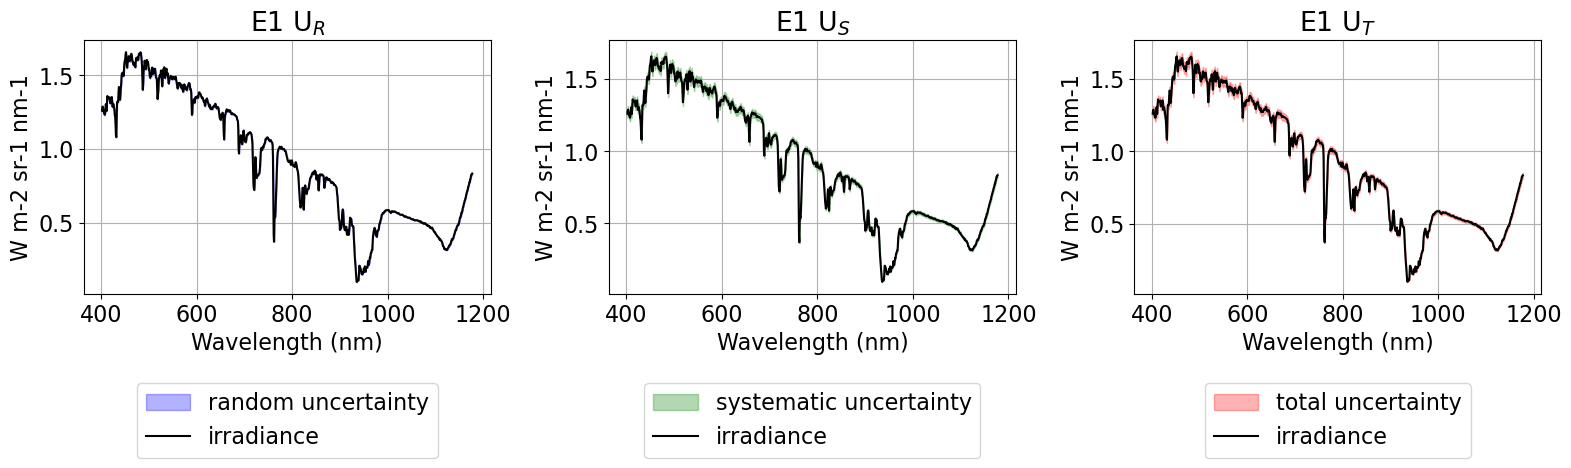

In [25]:
label = 'irradiance'
units = 'W m-2 sr-1 nm-1'
symbol = 'E1'

plot_absolute_u(Wvl, E1, E1_ur, E1_us, E1_ut, label, units, symbol)

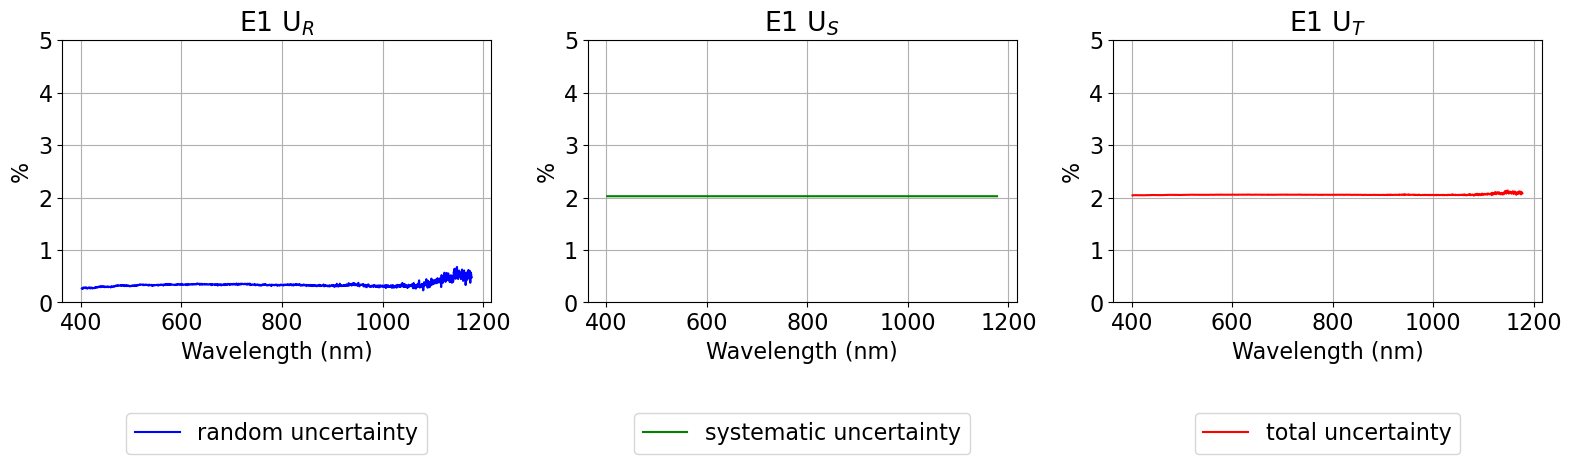

In [26]:
units = '%'
symbol = 'E1'

plot_relative_u(Wvl, E1, E1_ur, E1_us, E1_ut, units, symbol)

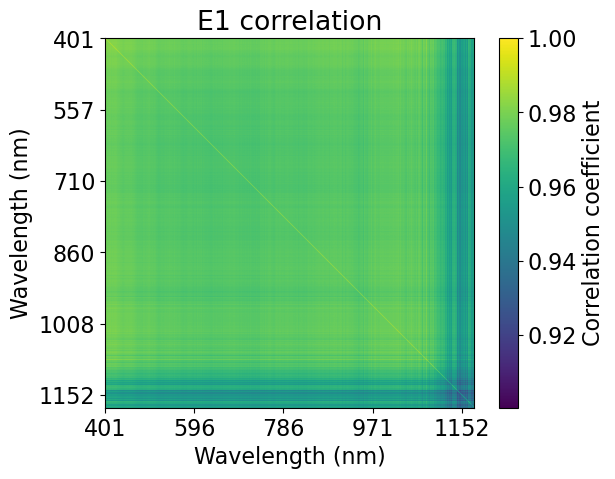

In [27]:
plot_cor_mat(E1_corr, 'E1')

### 4-3
### reflectance
[back to TOC](#TOC)

In [28]:
#uncertainty propagation for your field reflectance data using only 
#the calibration uncertainty and calibration coefficients together with dark and light field data

prop = punpy.MCPropagation(10000)

R1 = deriveR(L1, E1)

R1_ur = prop.propagate_random(deriveR, 
                              [L1, E1],
                              [L1_ur,E1_ur]) #random uncertainty cal_coef_L_ur

R1_us = prop.propagate_systematic(deriveR, 
                                  [L1, E1],
                                  [L1_us, E1_us]) # systematic uncertainty

R1_ut = (R1_ur**2 + R1_us**2)**0.5 # total uncertainty

R1_cov = punpy.convert_corr_to_cov(np.eye(len(R1_ur)), R1_ur) + \
         punpy.convert_corr_to_cov(np.ones((len(R1_us), len(R1_us))), R1_us)

R1_corr = punpy.correlation_from_covariance(R1_cov)

print("R1:    ", R1)
print("R1_ur: ", R1_ur)
print("R1_us: ", R1_us)
print("R1_ut: ", R1_ut)
print("R1_cov:\n", R1_cov)
print("R1_corr:\n", R1_corr)

R1:     [0.02428903 0.02456619 0.02483597 ... 0.20763381 0.20062118 0.20523402]
R1_ur:  [0.00013988 0.00015938 0.00015344 ... 0.00267874 0.00228344 0.00200178]
R1_us:  [0.00087655 0.00088656 0.00089629 ... 0.00749318 0.0072401  0.00740657]
R1_ut:  [0.00088764 0.00090077 0.00090933 ... 0.0079576  0.00759165 0.00767231]
R1_cov:
 [[7.87909949e-07 7.77112230e-07 7.85646109e-07 ... 6.56816338e-06
  6.34633003e-06 6.49224988e-06]
 [7.77112230e-07 8.11382187e-07 7.94611055e-07 ... 6.64311218e-06
  6.41874750e-06 6.56633243e-06]
 [7.85646109e-07 7.94611055e-07 8.26880030e-07 ... 6.71606369e-06
  6.48923515e-06 6.63844079e-06]
 ...
 [6.56816338e-06 6.64311218e-06 6.71606369e-06 ... 6.33233498e-05
  5.42513432e-05 5.54987331e-05]
 [6.34633003e-06 6.41874750e-06 6.48923515e-06 ... 5.42513432e-05
  5.76331576e-05 5.36243172e-05]
 [6.49224988e-06 6.56633243e-06 6.63844079e-06 ... 5.54987331e-05
  5.36243172e-05 5.88644173e-05]]
R1_corr:
 [[1.         0.97192492 0.97334638 ... 0.92987316 0.94177716 

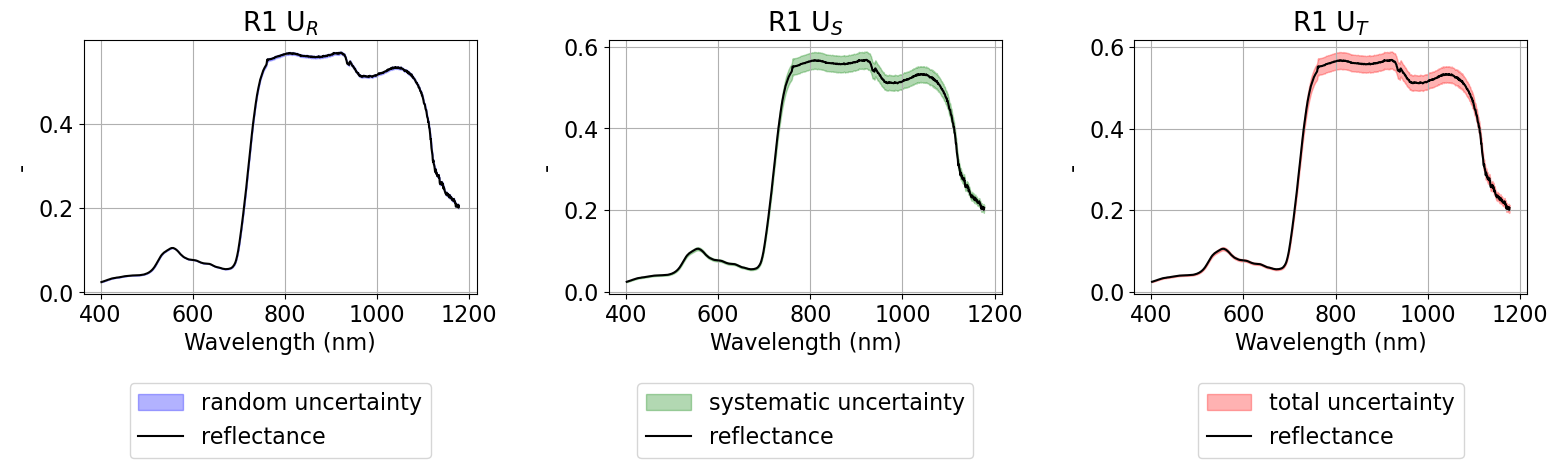

In [29]:
label = 'reflectance'
units = '-'
symbol = 'R1'

plot_absolute_u(Wvl, R1, R1_ur, R1_us, R1_ut, label, units, symbol)

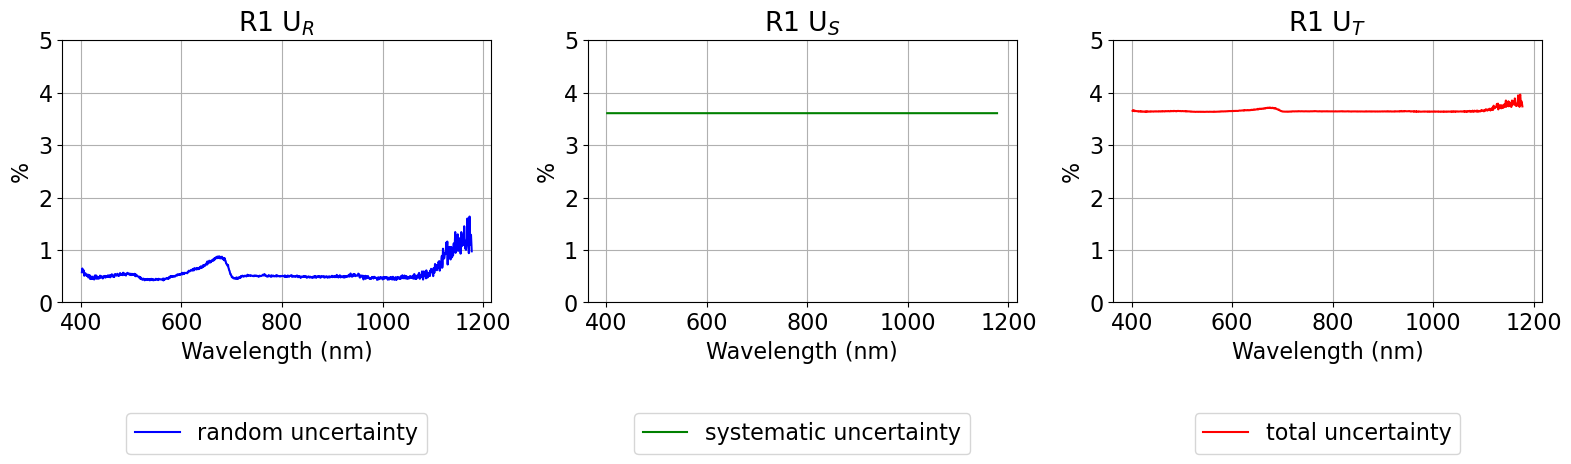

In [30]:
units = '%'
symbol = 'R1'

plot_relative_u(Wvl, R1, R1_ur, R1_us, R1_ut, units, symbol)

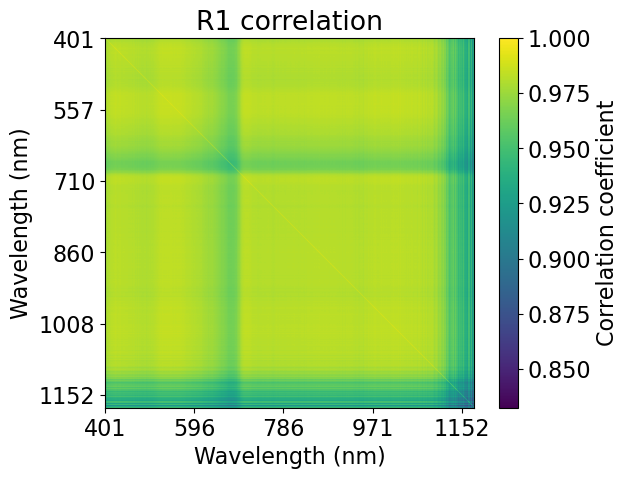

In [31]:
plot_cor_mat(R1_corr, 'R1')

# 5
## Analysis and export 

[back to TOC](#TOC)

## 5-1
### plotting together
[back to TOC](#TOC)

In [32]:
def plot_relative_u_ax(Wvl, x, ur, us, ut, units, symbol, ax=ax):
    ax.plot(Wvl, ur / x * 100, color="blue", label="random uncertainty")
    
    ax.plot(Wvl, us / x * 100, color="green", label="systematic uncertainty") 

    ax.plot(Wvl, ut / x * 100, color="red", label="total uncertainty")
 
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel(units)
    ax.grid()
    ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')
    ax.set_ylim([0, 5])
    ax.set_title(f"{symbol} U")

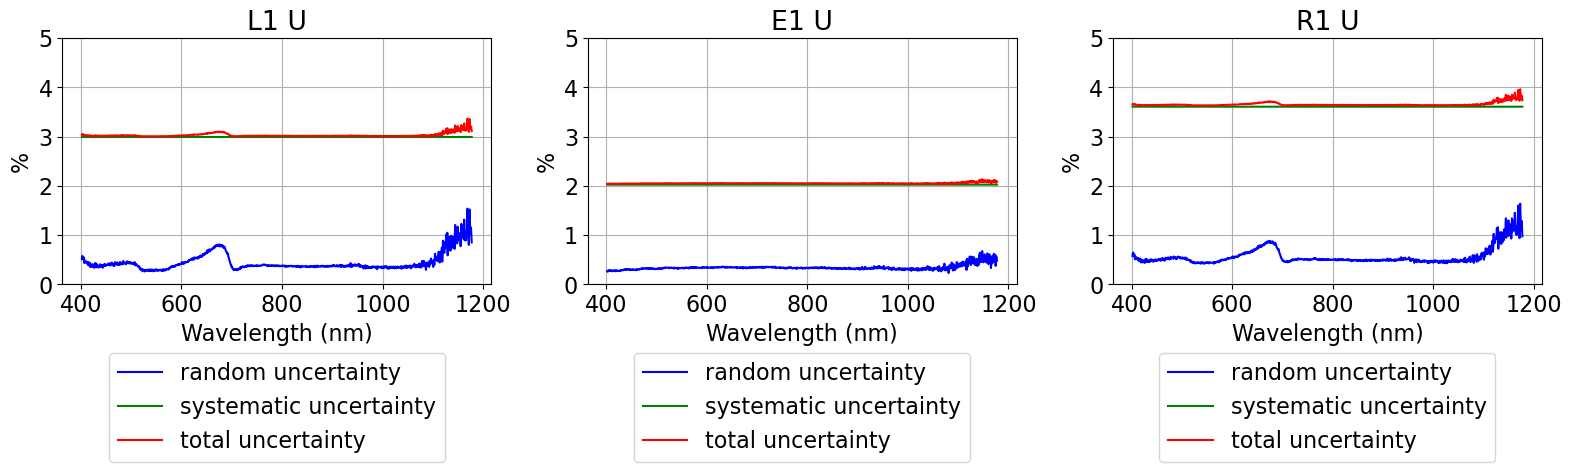

In [33]:
_, axs = plt.subplots(1, 3, figsize=(16, 4.5), tight_layout=True)
units = '%'

ax = axs[0]
symbol = 'L1'
plot_relative_u_ax(Wvl, L1, L1_ur, L1_us, L1_ut, units, symbol, ax)

ax = axs[1]
symbol = 'E1'
plot_relative_u_ax(Wvl, E1, E1_ur, E1_us, E1_ut, units, symbol, ax)

ax = axs[2]
symbol = 'R1'
plot_relative_u_ax(Wvl, R1, R1_ur, R1_us, R1_ut, units, symbol, ax)

#### correlation matrix

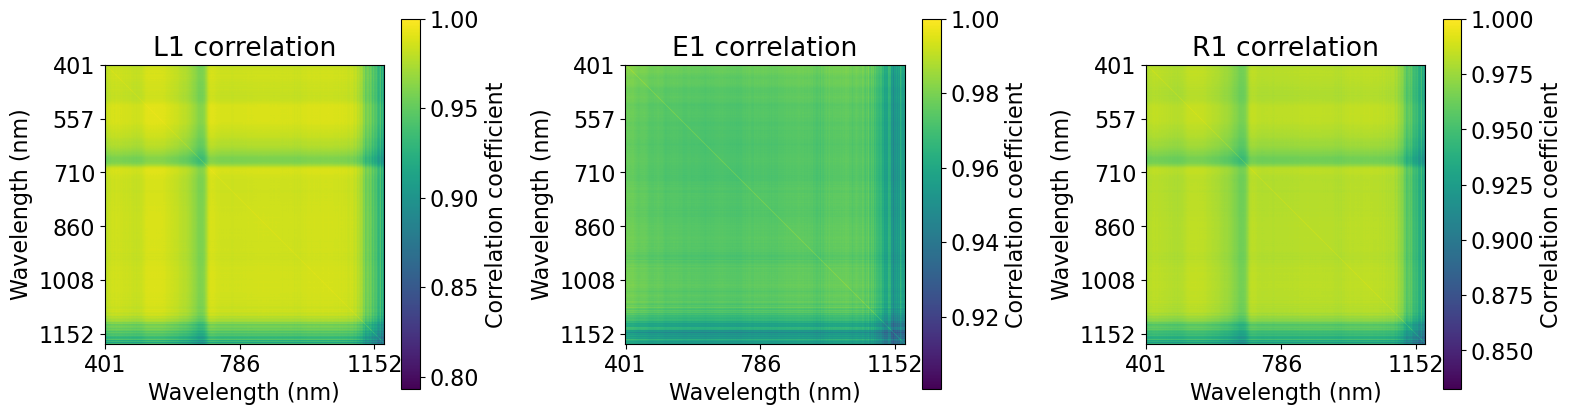

In [34]:
_, axs = plt.subplots(1, 3, figsize=(16, 4.5), tight_layout=True)
units = '%'

ax = axs[0]
plot_cor_mat(L1_corr, 'L1', ax)

ax = axs[1]
plot_cor_mat(E1_corr, 'E1', ax)

ax = axs[2]
plot_cor_mat(R1_corr, 'R1', ax)

## 5-2
### Export
[back to TOC](#TOC)

In [35]:
df = pd.DataFrame(
    {'wl': Wvl,
     'refl': R1,
     'refl_u': R1_ut
    }).set_index('wl')

df.head()

,refl,refl_u
wl,,
401.82374,0.024289,0.000888
402.61047,0.024566,0.000901
403.39714,0.024836,0.000909
404.18373,0.025091,0.000918
404.97025,0.025378,0.000929


In [36]:
# df.to_csv('R1_ut.csv')